In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Outline
1. remove outlier
2. Forecasting
3. Time series cross validation
4. Lag Features
5. Predicting the feature

In [4]:
df = pd.read_csv('archive/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


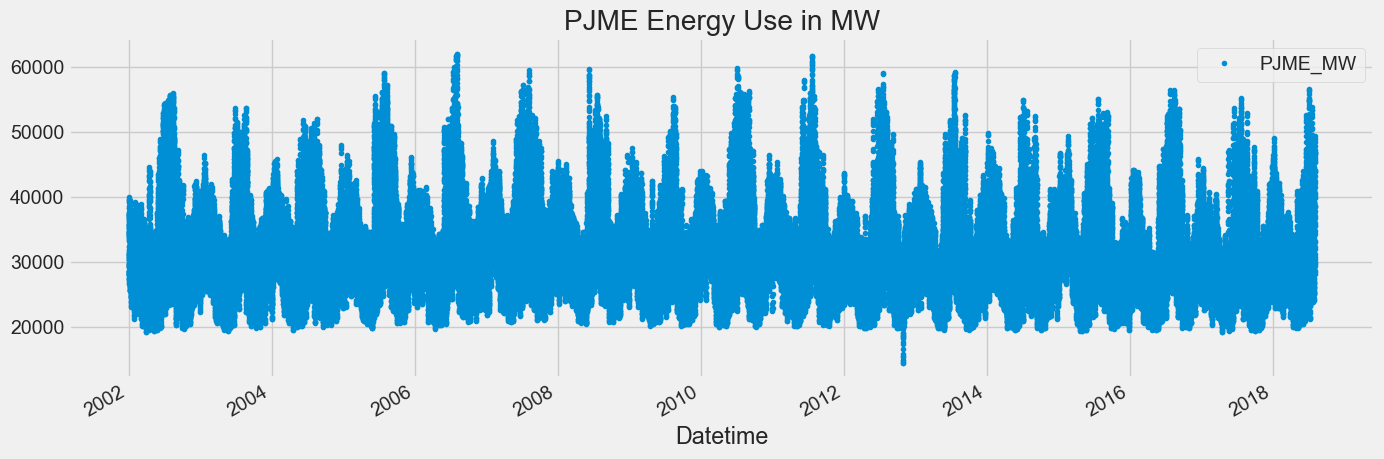

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<AxesSubplot: ylabel='Frequency'>

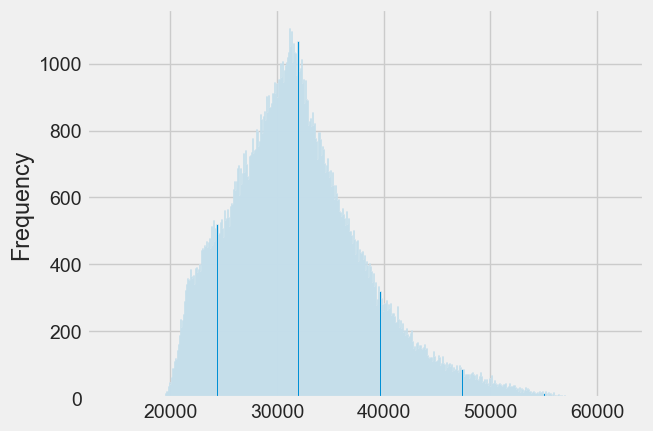

In [6]:
# Analysis Outlier
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot: xlabel='Datetime'>

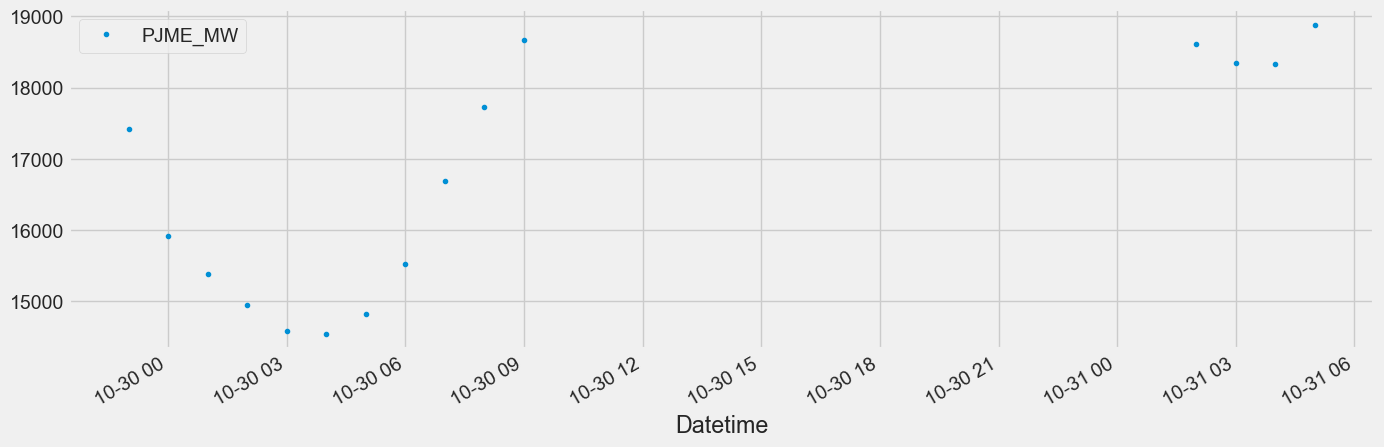

In [7]:
df.query('PJME_MW < 19_000').plot(figsize=(15, 5), style='.')

In [8]:
# Remove outlier
df = df.query('PJME_MW > 19_000').copy()

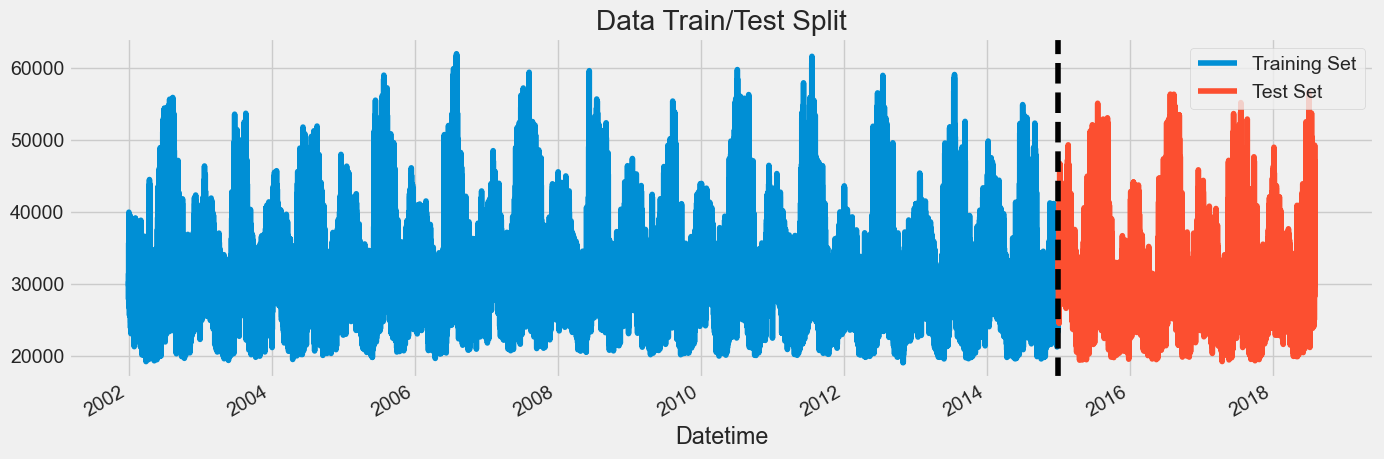

In [9]:
# Train / Test split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [10]:
# Time Series Cross Validation
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

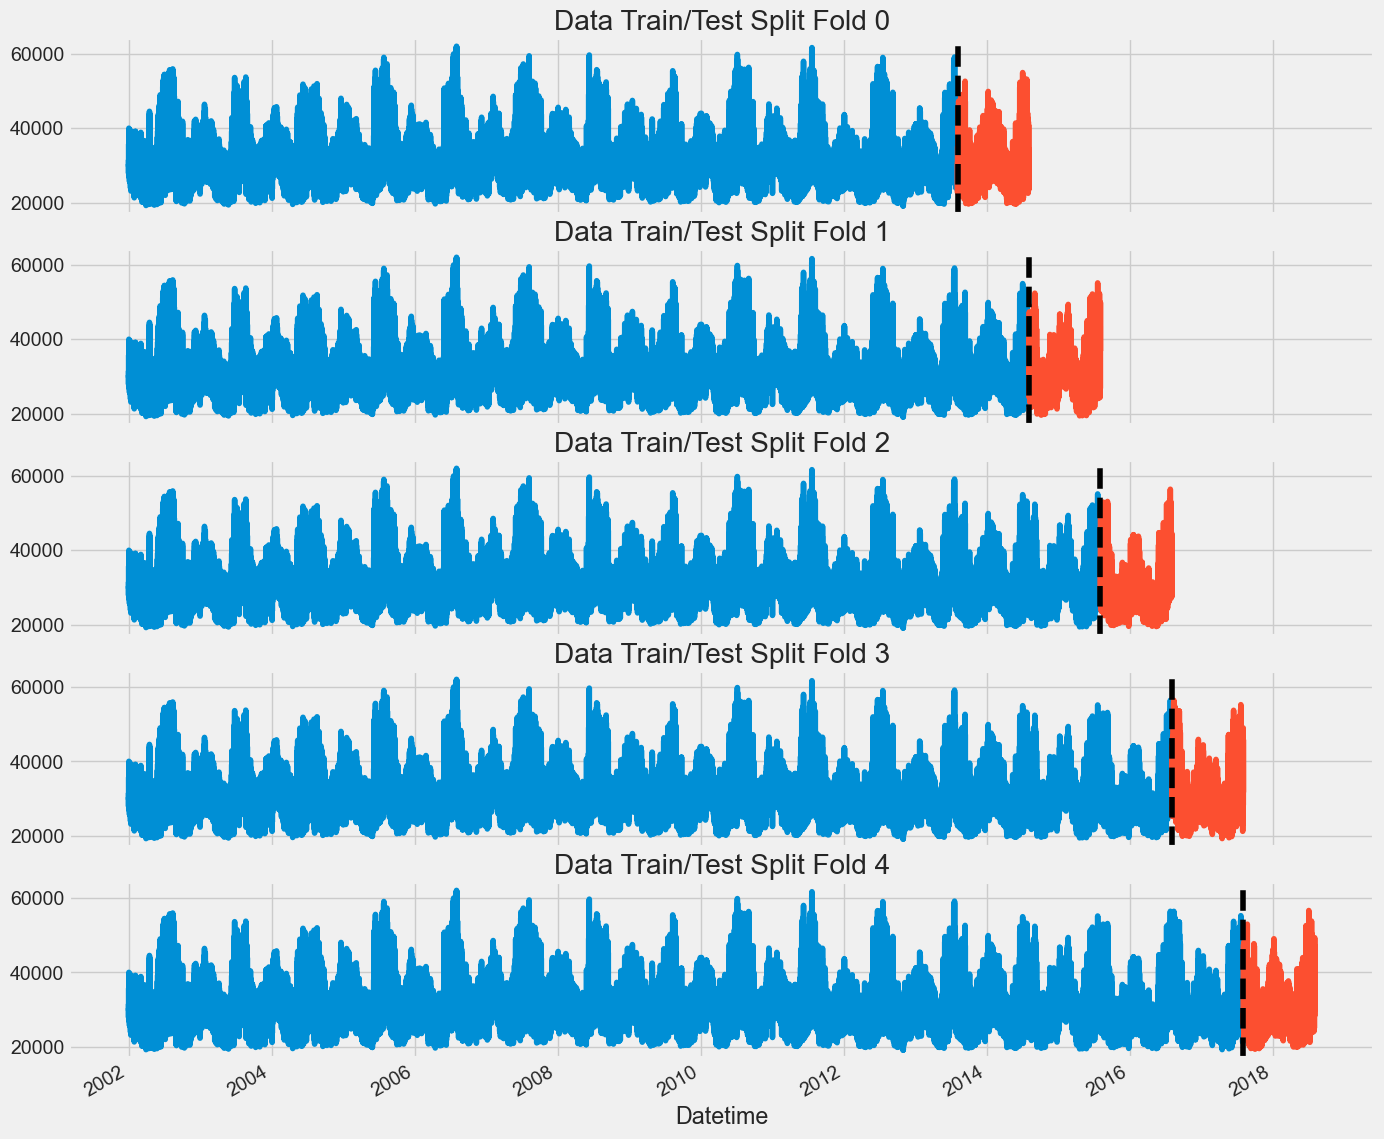

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15),
                             sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1


In [12]:
# The forecast horizon is the length of time onto the future for which forecasts to are to be prepared.
# These generally vary from short-term forcasting horizons to long-term horizon.
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [13]:
# Lag features: what was the target(x) days in the past
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1']=(df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2']=(df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3']=(df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [15]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [16]:
# Train using Cross Validation
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']

    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=True)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[1]	validation_0-rmse:32410.58949	validation_1-rmse:31637.44020
[2]	validation_0-rmse:32091.94820	validation_1-rmse:31322.59030
[3]	validation_0-rmse:31776.53001	validation_1-rmse:31008.18277
[4]	validation_0-rmse:31464.32859	validation_1-rmse:30698.66061
[5]	validation_0-rmse:31155.25209	validation_1-rmse:30391.56089
[6]	validation_0-rmse:30849.31931	validation_1-rmse:30086.61590
[7]	validation_0-rmse:30546.53176	validation_1-rmse:29787.29230
[8]	validation_0-rmse:30246.73679	validation_1-rmse:29487.50370
[9]	validation_0-rmse:29950.03593	validation_1-rmse:29190.39005
[10]	validation_0-r

In [17]:
print(f"Score across folds: {np.mean(scores):0.4f}")
print(f"Fold scores: {scores}")

Score across folds: 3806.3258
Fold scores: [3780.828736907443, 3434.3528874818867, 3721.087048520642, 4071.2024483662153, 4024.157699780812]


In [18]:
# Predicting the Feature:
# 1. Retraining all the data
# 2. To Predict the future we need an empty dataframe for future data ranges.
# 3. Run those dates through our feature creation code and lag creation

# Retrain all the data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01
                        )
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=True)

[16:44:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[1]	validation_0-rmse:32085.31724
[2]	validation_0-rmse:31769.98498
[3]	validation_0-rmse:31457.86809
[4]	validation_0-rmse:31148.90733
[5]	validation_0-rmse:30843.08828
[6]	validation_0-rmse:30540.36264
[7]	validation_0-rmse:30240.74559
[8]	validation_0-rmse:29944.12962
[9]	validation_0-rmse:29650.57655
[10]	validation_0-rmse:29359.96524
[11]	validation_0-rmse:29072.35543
[12]	validation_0-rmse:28787.61582
[13]	validation_0-rmse:28505.83822
[14]	validation_0-rmse:28226.85171
[15]	validation_0-rmse:27950.78774
[16]	validation_0-rmse:27677.43802
[17]	validation_0-rmse:27406.93261
[18]	validation_0-rmse:27139.14544
[19]	validation_0-rmse:26874.09059
[20]	validation_0-rmse:26611.81057
[21]	validation_0-rmse:26352.11031
[22]	validation_0-rmse:26095.15989
[23]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [19]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [23]:
# Create future dataframe
future = pd.date_range(start='2018-08-03', end='2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [25]:
feature_with_feature = df_and_future.query('isFuture').copy()
feature_with_feature

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


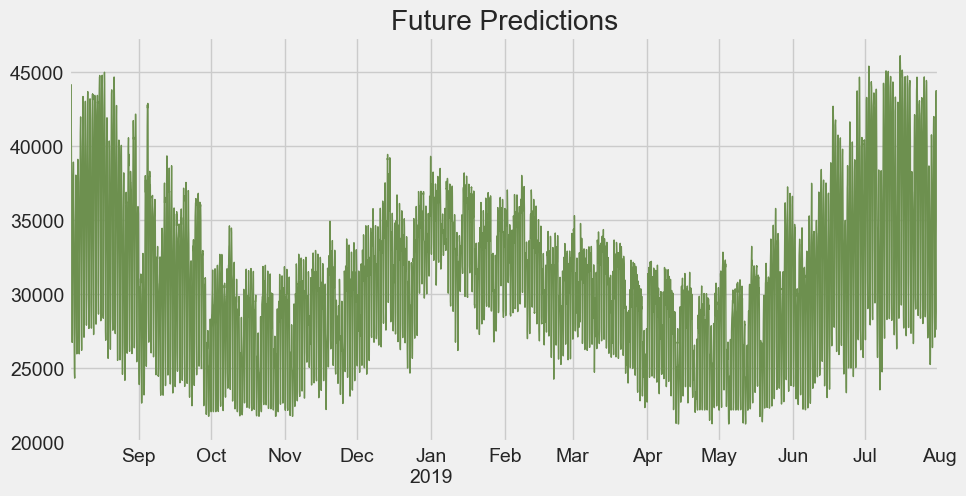

In [28]:
# Predict future
feature_with_feature['pred'] = reg.predict(feature_with_feature[FEATURES])
feature_with_feature['pred'].plot(figsize=(10, 5),
                                  color=color_pal[3],
                                  ms=1,
                                  lw=1, title='Future Predictions')
plt.show()

In [29]:
# Save and load model
reg.save_model('model.json')
!ls -lh

total 4456
-rw-r--r--   1 chris  staff   517K Jan 12 06:08 Time-Series-Forcasting.ipynb
-rw-r--r--   1 chris  staff   1.1M Jan 12 16:56 Time-Series-Forcasting2.ipynb
drwxr-xr-x@ 16 chris  staff   512B Jan  7 18:09 archive
-rw-r--r--   1 chris  staff   571K Jan 12 16:56 model.json


In [30]:
reg_second = xgb.XGBRegressor()
reg_second.load_model('model.json')

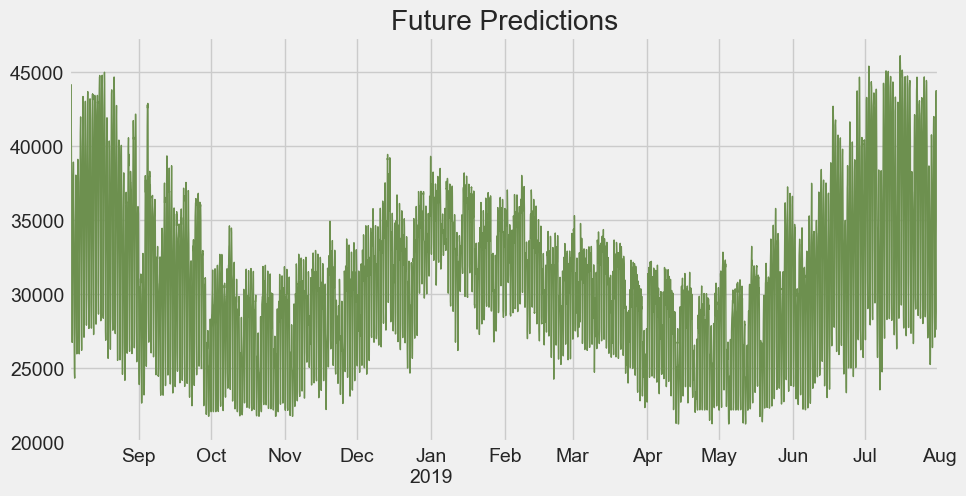

In [31]:
# Second predict feature
feature_with_feature['pred'] = reg_second.predict(feature_with_feature[FEATURES])
feature_with_feature['pred'].plot(figsize=(10, 5),
                                  color=color_pal[3],
                                  ms=1,
                                  lw=1, title='Future Predictions')
plt.show()